# Shape analysis of closed curves

In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import subprocess

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(geomstats_gitroot_path[:-1])

from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    DynamicProgrammingAligner,
    SymmetricParameterBasedAlignment,
)


print("Working directory: ", os.getcwd())

INFO: Using pytorch backend


Working directory:  /home/luisfpereira/Repos/github/geomstats


In [2]:
import geomstats.backend as gs
import json
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    insert_zeros,
    DynamicProgrammingAligner,
)

In [3]:
def load_curve(filename):
    f = open(filename)
    data = json.load(f)

    points_list = data["points"]
    x_coord = []
    y_coord = []
    for point in points_list:
        x_coord.append(point["x"])
        y_coord.append(point["y"])

    return gs.vstack((gs.array(x_coord), gs.array(y_coord))).T


def plot_curve(curve, fmt="o-k", translation=None, ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    if add_origin:
        curve = insert_zeros(curve, axis=-2)
        if translation is not None:
            curve = curve + translation
    ax.plot(curve[:, 0], curve[:, 1], fmt)

    return ax


def resample(curve, k_sampling_points):
    t_space = gs.linspace(0.0, 1.0, curve.shape[0])
    spline_fun = make_interp_spline(t_space, curve)
    sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)
    return gs.from_numpy(spline_fun(sampling_points))


def plot_geodesic(geod, n_times_plot, translation=None, ax=None, figsize=(7, 7)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "or")

    n_times = geod.shape[0]
    indices = gs.floor(gs.linspace(0.0, n_times - 1, n_times_plot)).astype("int")
    for i in range(1, n_times_plot - 1):
        ax.plot(geod[indices[i], :, 0], geod[indices[i], :, 1], "k")

    return ax

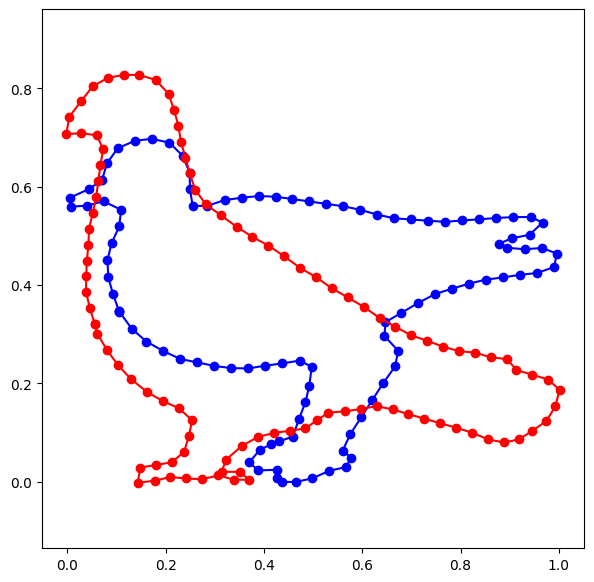

In [4]:
filename_a = "geomstats/datasets/data/shapes/bird-1.json"
filename_b = "geomstats/datasets/data/shapes/bird-18.json"

curve_a = load_curve(filename_a)
curve_b = load_curve(filename_b)

k_sampling_points = 100
curve_a = resample(curve_a, k_sampling_points)
curve_b = resample(curve_b, k_sampling_points)

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.axis("equal")
plt.show()

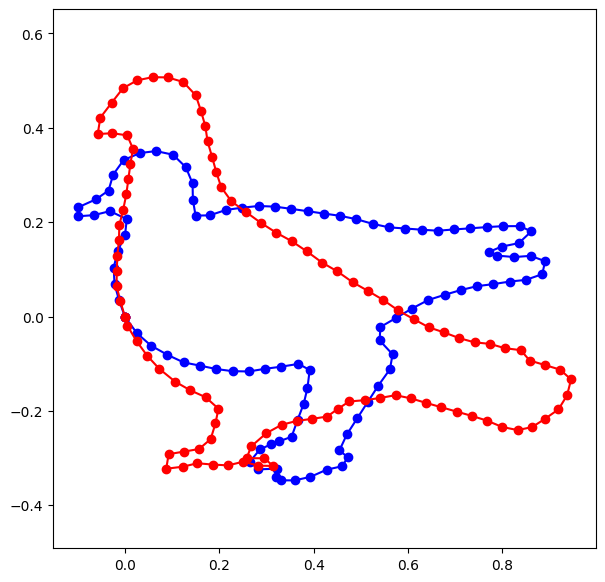

In [5]:
curves_r2 = DiscreteCurvesStartingAtOrigin(2, k_sampling_points)

curve_a0 = curves_r2.projection(curve_a)
curve_b0 = curves_r2.projection(curve_b)

ax = plot_curve(curve_a0, "o-b")
plot_curve(curve_b0, "o-r", ax=ax)
plt.axis("equal")
plt.show()

In [6]:
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

In [7]:
def plot_curve(curve, style="o-b"):
    plt.plot(curve[:, 0], curve[:, 1], style)

In [8]:
total_space = curves_r2
base_point = curve_a0
point = curve_b0

tensor(4.3484)

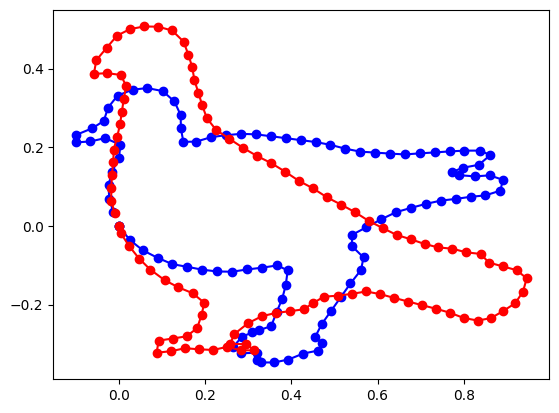

In [9]:
plt.scatter(0.0, 0.0)
plot_curve(base_point, "o-b")
plot_curve(point, "o-r")

total_space.metric.squared_dist(point, base_point)

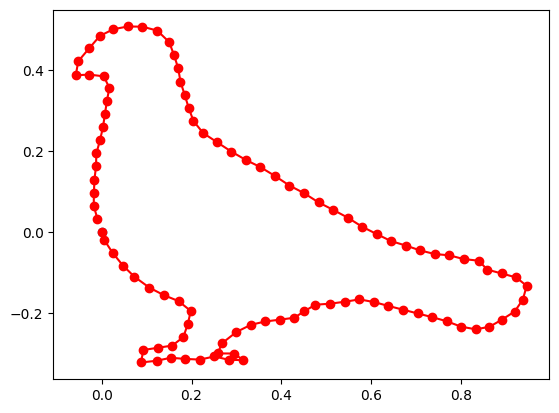

In [10]:
plt.scatter(0.0, 0.0)
plot_curve(point, "o-r")

In [11]:
aligner = SymmetricParameterBasedAlignment(total_space)

aligner.optimizer.save_result = True

In [18]:
aligned = aligner._align_single(total_space, point, base_point)

print(aligner.optimizer.result_)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2.3874281249777436
        x: tensor([20.7402,  4.8768])
      nit: 21
      jac: tensor([2.6679e-10, 3.4953e-09])
     nfev: 28
     njev: 28
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [13]:
base_point_fparam, point_fparam = gs.split(aligner.optimizer.result_.x, 2)

new_base_point = aligner.fp_group_action_base_point(base_point_fparam)
new_point = aligner.fp_group_action_point(point_fparam)

(tensor(4.3484), tensor(3.2158), tensor(0.4535))

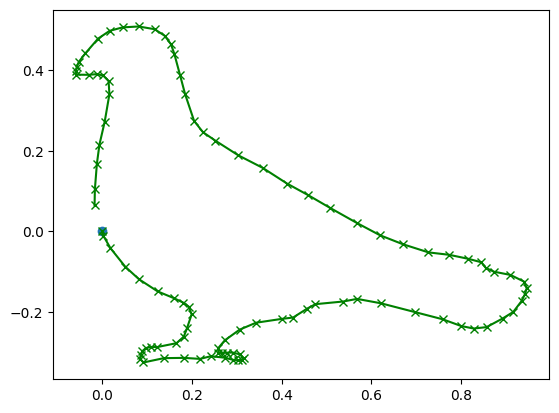

In [14]:
aligned = aligner._align_single(total_space, point, base_point)

plt.scatter(0.0, 0.0)
# plot_curve(point, 'o--r')
plot_curve(aligned, "x-g")

(
    total_space.metric.squared_dist(point, base_point),
    total_space.metric.squared_dist(aligned, base_point),
    gs.abs(total_space.length(point) - total_space.length(aligned)),
)

(tensor(4.3484), tensor(4.3085), tensor(0.4439))

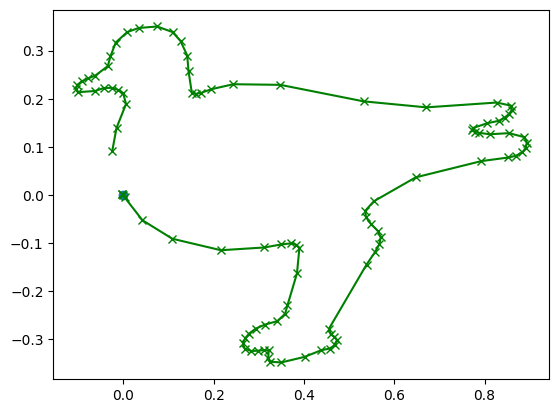

In [15]:
aligned_base_point = aligner._align_single(total_space, base_point, point)

plt.scatter(0.0, 0.0)
# plot_curve(base_point, 'o--b')
plot_curve(aligned_base_point, "x-g")

(
    total_space.metric.squared_dist(base_point, point),
    total_space.metric.squared_dist(aligned_base_point, point),
    gs.abs(total_space.length(base_point) - total_space.length(aligned)),
)

In [16]:
geod_fun = total_space.metric.geodesic(
    initial_point=new_base_point, end_point=new_point
)

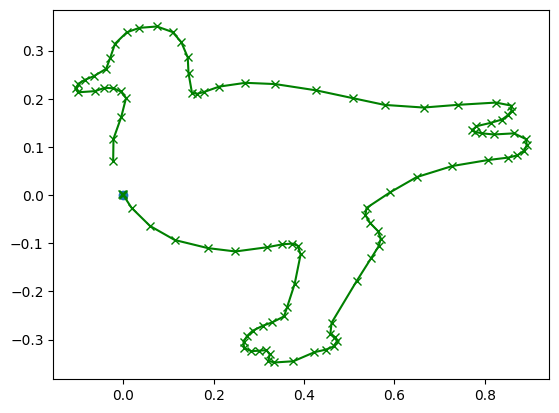

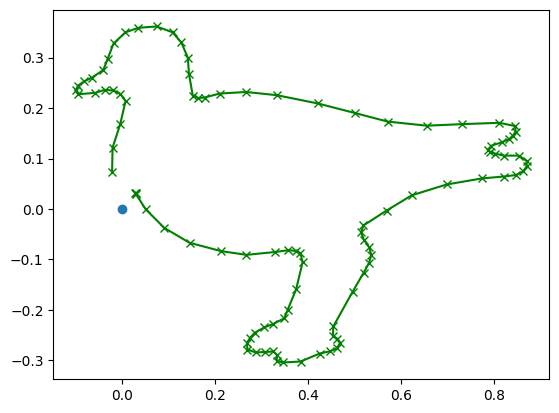

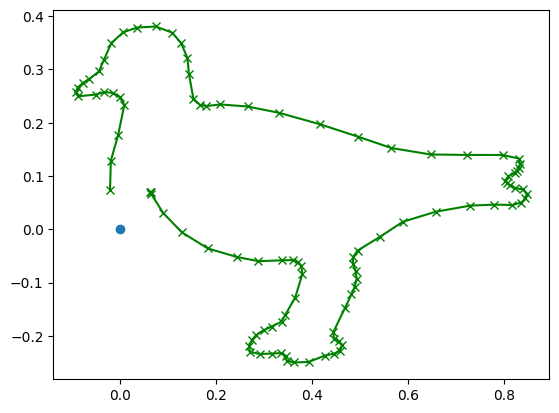

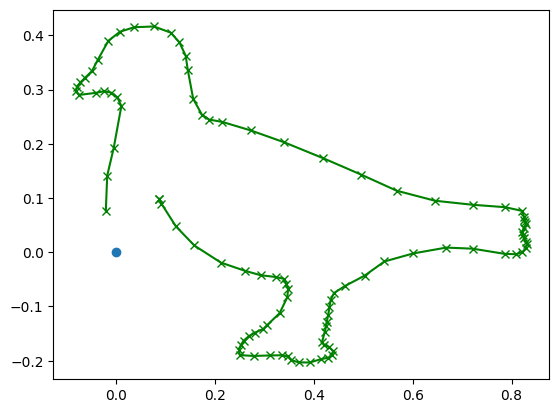

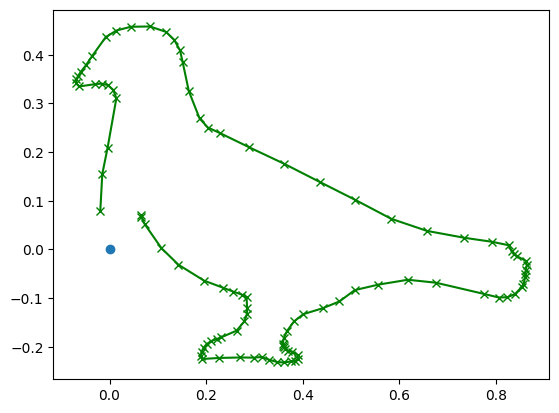

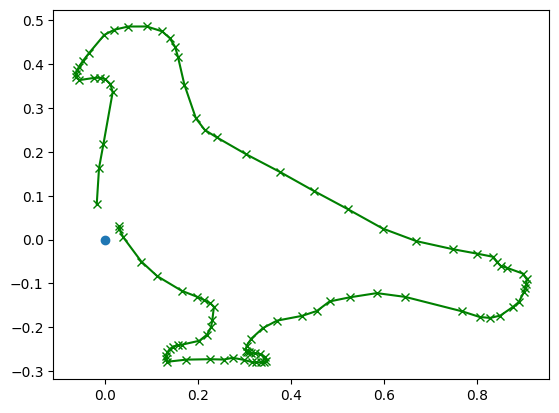

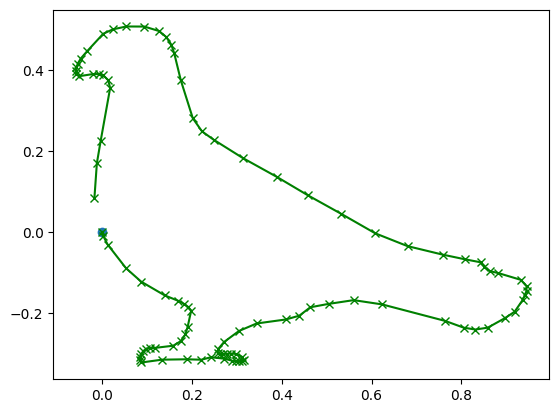

In [17]:
time = gs.array([0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0])
save = False
path = "/home/luisfpereira/Desktop/tests_alignment"


geod_pts = geod_fun(time)

for t, geod_pt in zip(time, geod_pts):
    plt.scatter(0.0, 0.0)
    plot_curve(geod_pt, "x-g")
    if save:
        plt.savefig(f"{path}/duck_{float(t):.2f}.png")
    plt.show()

In [20]:
aligner_dyn = DynamicProgrammingAligner()

tensor(0.9122)


(tensor(4.3484), tensor(1.5962), tensor(0.3192))

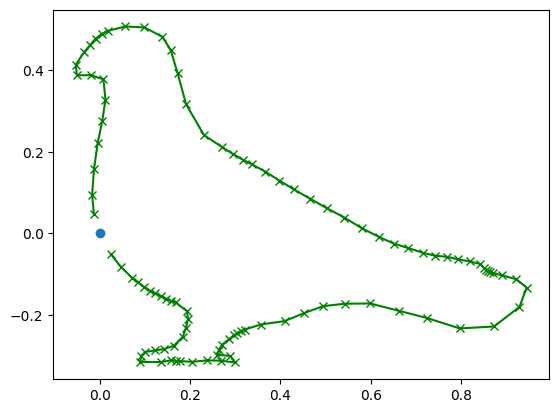

In [21]:
aligned, sdist = aligner_dyn._align_single(
    total_space, point, base_point, return_sdist=True
)

plt.scatter(0.0, 0.0)

# plot_curve(point, 'o-r')
plot_curve(aligned, "x-g")


print(sdist)
(
    total_space.metric.squared_dist(point, base_point),
    total_space.metric.squared_dist(aligned, base_point),
    gs.abs(total_space.length(point) - total_space.length(aligned)),
)

tensor(0.9122)


(tensor(4.3484), tensor(1.5207), tensor(0.3096))

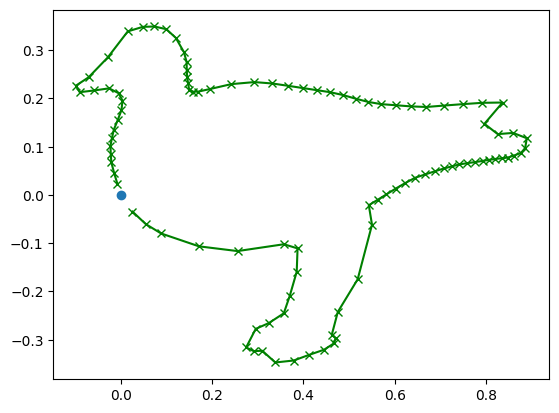

In [22]:
aligned_base_point, sdist = aligner_dyn._align_single(
    total_space, base_point, point, return_sdist=True
)

plt.scatter(0.0, 0.0)
# plot_curve(base_point, 'o--r')
plot_curve(aligned_base_point, "x-g")

print(sdist)
(
    total_space.metric.squared_dist(base_point, point),
    total_space.metric.squared_dist(aligned_base_point, point),
    gs.abs(total_space.length(base_point) - total_space.length(aligned)),
)

In [ ]:
n_times = 100
times = gs.linspace(0.0, 1.0, n_times)
geodesic_1 = curves_r2.metric.geodesic(curve_a0, curve_b0)(times)

In [ ]:
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

geodesic_2 = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0)(times)

In [ ]:
curves_r2.fiber_bundle.aligner = DynamicProgrammingAligner()

geodesic_3 = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0)(times)

In [ ]:
vec = gs.array([5.0, 0.0])
translation = gs.linspace(gs.zeros(2), vec, n_times)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
plot_geodesic(geodesic_1, 5, translation=translation, ax=ax1)
ax1.set_title("SRV geodesic")

plot_geodesic(geodesic_2, 5, translation=translation, ax=ax2)
plot_curve(curve_b0, "r", ax=ax2, translation=vec)
ax2.set_title("Quotient SRV geodesic with Iterative Horizontal Geodesic aligner")

plot_geodesic(geodesic_3, 5, translation=translation, ax=ax3)
plot_curve(curve_b0, "r", ax=ax3, translation=vec)
ax3.set_title("Quotient SRV geodesic with Dynamic Programming aligner")
plt.show()